In [1]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux
using Flux: onecold, @epochs

┌ Info: Kinetic will run serially
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/5jIce/src/KitBase.jl:61
┌ Info: Kinetic will run with CUDA
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/5jIce/src/KitBase.jl:65
┌ Info: 1: NVIDIA GeForce RTX 3070
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/5jIce/src/KitBase.jl:67
┌ Info: Scalar operation is disabled in CUDA
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/5jIce/src/KitBase.jl:69


In [2]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, [1.0, 0.0], [0.0, 1.0])
    return x, y
end

function regime_number(Y, rg=1)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Y)
    Y1 = nn(X)

    YA1 = [onecold(Y1[:, i]) for i in axes(Y1, 2)]
    YA = [onecold(Y[:, i]) for i in axes(Y, 2)]

    accuracy = 0.0
    for i in eachindex(YA)
        if YA[i] == YA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(YA)

    return accuracy
end

accuracy (generic function with 1 method)

### Dataset

In [3]:
file = open("a3_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end]
nd = length(pdfs) ÷ 2

500

In [4]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])

VelocitySpace1D{Float64,Int64,Vector{Float64},Vector{Float64}}
domain: (-5.0,5.0)
resolution: 100
ghost: 0


In [5]:
dist = Uniform(0.0001, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.000001, 1.0)
kns = rand(dist, nd);

In [6]:
X = zeros(7, nd)
Y = zeros(2, nd)
for i = 1:nd
    #fL = pdfs[i]; fR = pdfs[nd*2-i]
    fL = pop!(pdfs); fR = pop!(pdfs) # shuffle
    wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
    #@show wL, wR
    w = @. (wL + wR) / 2
    sw = @. (wR - wL) / dxs[i]
    f = @. (fL + fR) / 2
    
    X[:, i], Y[:, i] = regime_data(w, sw, f, vs.u, 0, kns[i])
end

In [7]:
regime_number(Y)

NS regime: 108 of 500


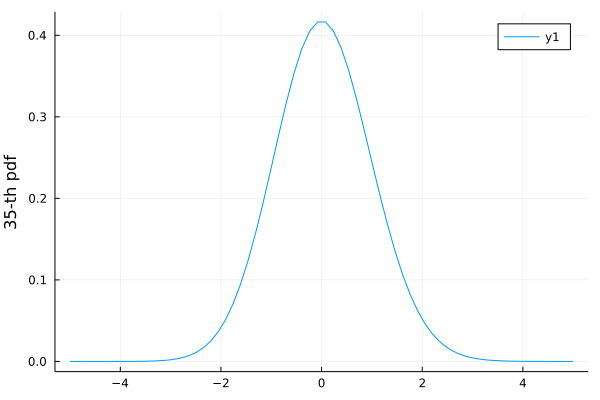

In [8]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Model

In [9]:
@load "../nn.jld2" nn

1-element Vector{Symbol}:
 :nn

In [10]:
accuracy(nn, X, Y)

0.78

In [11]:
data = Flux.Data.DataLoader((X, Y), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
loss(x, y) = sum(abs2, nn(x) - y) / size(x, 2) #+ 1e-6 * sum(sqnorm, ps)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [14]:
@epochs 100 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

loss: 0.2268393221682696


┌ Info: Epoch 1
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2329246144512409


┌ Info: Epoch 2
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2315069051888967


┌ Info: Epoch 3
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.235145754716426
loss: 0.22522334432381752


┌ Info: Epoch 4
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 5
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23299661105435113


┌ Info: Epoch 6
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22807463712035678


┌ Info: Epoch 7
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23007206262437824


┌ Info: Epoch 8
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22604936149344168
loss: 0.23594917424558218


┌ Info: Epoch 9
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 10
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2446462198836628


┌ Info: Epoch 11
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23093770768946925


┌ Info: Epoch 12
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22471007458034195
loss: 0.22603531739420868


┌ Info: Epoch 13
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 14
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2253307132770676


┌ Info: Epoch 15
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24249232007537835


┌ Info: Epoch 16
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2473177942561911
loss: 0.22871334491971032


┌ Info: Epoch 17
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 18
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23258670620551622


┌ Info: Epoch 19
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22356745863899177


┌ Info: Epoch 20
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22302761986607672


┌ Info: Epoch 21
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 22
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23121530709500654
loss: 0.22411573444880883


┌ Info: Epoch 23
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2292151872791846


┌ Info: Epoch 24
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.220779558686386


┌ Info: Epoch 25
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2287927360512102
loss: 0.2164313302594969


┌ Info: Epoch 26
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 27
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23556247628076538


┌ Info: Epoch 28
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2219360741936034


┌ Info: Epoch 29
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24093722097145395


┌ Info: Epoch 30
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23950815797705938
loss: 0.2239114599452683


┌ Info: Epoch 31
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 32
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2256363938590503


┌ Info: Epoch 33
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22963372589453235


┌ Info: Epoch 34
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22849198041240018
loss: 0.22582357116065224


┌ Info: Epoch 35
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 36
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22412465361166883


┌ Info: Epoch 37
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2179997287244694


┌ Info: Epoch 38
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23299416861766953
loss: 0.22129739804507007


┌ Info: Epoch 39
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 40
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23613042143811822


┌ Info: Epoch 41
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.26425366461270694


┌ Info: Epoch 42
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21964055478644087
loss: 0.21204058509336937


┌ Info: Epoch 43
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 44
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2099831805838173


┌ Info: Epoch 45
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2189433371226097


┌ Info: Epoch 46
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2162328728162202


┌ Info: Epoch 47
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23990588866221826
loss: 0.21841569982505538


┌ Info: Epoch 48
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 49
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2188163148096779


┌ Info: Epoch 50
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2100837713797802


┌ Info: Epoch 51
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22895499111382728


┌ Info: Epoch 52
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22211258164862963
loss: 0.20921232564055217


┌ Info: Epoch 53
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 54
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.210490748710452


┌ Info: Epoch 55
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2170403188092488
loss: 0.21847292914400804


┌ Info: Epoch 56
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 57
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21052626170386948


┌ Info: Epoch 58
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21477989440464842


┌ Info: Epoch 59
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21034257825522548


┌ Info: Epoch 60
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22469849694233218
loss: 0.20831866054032705


┌ Info: Epoch 61
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 62
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21904226213050848


┌ Info: Epoch 63
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.209425349938029


┌ Info: Epoch 64
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20786061607169662
loss: 0.22066745569495994


┌ Info: Epoch 65
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 66
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21145955338010922


┌ Info: Epoch 67
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22587203396536962


┌ Info: Epoch 68
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2094311086190034
loss: 0.20432602889767693


┌ Info: Epoch 69
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 70
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20806223771257754


┌ Info: Epoch 71
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23438888770119068


┌ Info: Epoch 72
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2130138945003327


┌ Info: Epoch 73
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22994937980002844
loss: 0.2122207614384434


┌ Info: Epoch 74
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 75
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.208165583050373


┌ Info: Epoch 76
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20869534752915633


┌ Info: Epoch 77
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21341805760250054
loss: 0.2078727222089563


┌ Info: Epoch 78
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 79
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2313048074065386


┌ Info: Epoch 80
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2111102584728212


┌ Info: Epoch 81
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20587790348975796
loss: 0.20563019562440407


┌ Info: Epoch 82
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 83
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21071158007668733


┌ Info: Epoch 84
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20164338480310365


┌ Info: Epoch 85
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20267602360465417
loss: 0.20759242299806402


┌ Info: Epoch 86
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 87
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21481451984502356


┌ Info: Epoch 88
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23030689294939152


┌ Info: Epoch 89
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20439560355077033


┌ Info: Epoch 90
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20672392153438962
loss: 0.2016555171023538


┌ Info: Epoch 91
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 92
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20636130919498472


┌ Info: Epoch 93
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20744072735596158


┌ Info: Epoch 94
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20532445273935998


┌ Info: Epoch 95
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.20595673169204692
loss: 0.21667410010681068


┌ Info: Epoch 96
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 97
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2041061553969591


┌ Info: Epoch 98
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1994417207644486


┌ Info: Epoch 99
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2138204572585951


┌ Info: Epoch 100
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


In [16]:
cd(@__DIR__)
@save "nn_rif.jld2" nn

### Test

In [15]:
accuracy(nn, X, Y)

0.872